# Network construction: first presentation

Network construction is aligned with the questions we aim to answer in the project. For this, the nodes represent the deputies. Two deputies are linked if their voting pattern is similar, which will be made clear below. We consider the votings that occurred during a period (year or legislature) in the plenary. 

First, you have to run the python scripts to obtain the necessary data. 

In [2]:
import pandas as pd
import numpy as np
import networkx as nx

from DadosAbertosBrasil import camara

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import time
from tqdm.notebook import trange, tqdm
import requests

api = "https://dadosabertos.camara.leg.br/api/v2/"
dados = "http://dadosabertos.camara.leg.br/arquivos/"

### Importing the votes

The table `votes_info.csv` has information about the votes we have. 

In [3]:
votings = pd.read_csv('../data/tables/votes_info.csv')
votings_plen = votings[votings.siglaOrgao=='PLEN']

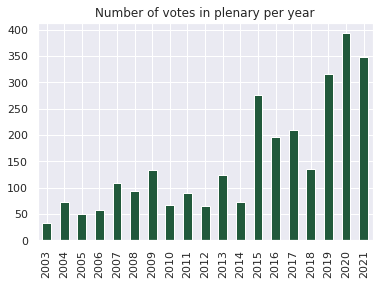

In [5]:
votings_plen.year.value_counts().sort_index().plot.bar(color='#21593b')
plt.title('Number of votes in plenary per year')
plt.show()

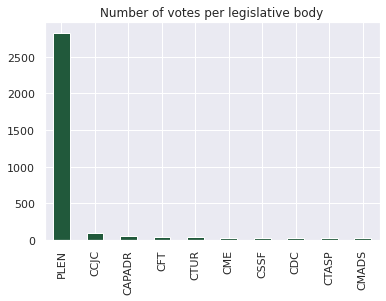

In [6]:
votings.siglaOrgao.value_counts().iloc[0:10].plot.bar(color='#21593b')
plt.title('Number of votes per legislative body')
plt.show()

Table `votes_deputies.csv` has information about how the deputies positioned themselves in each vote. There is some types of votes:

- Sim/Não (Yes/No): In favor/Against the topic discussed and voted. 
- Obstrução (Obstruction): Artifice used to delay the voting. It doesn't count as quorum. 
- Abstenção (Abstention): The deputy has no opinion about the topic. 
- Secreto (Secret): The voting was secret, then there is no information about how the deputies voted. 
- Artigo 17 (Article 17): The president of the Chamber of Deputies can vote in secret ballot. 
- Favorável com restrições/Branco: These are rare and occured only in the past. 

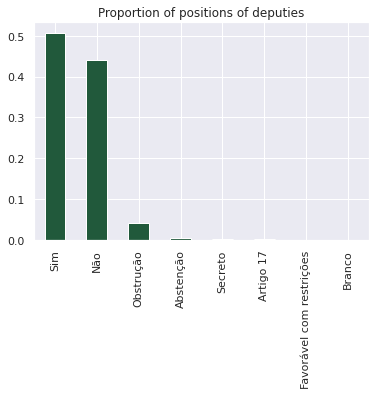

In [9]:
votings_deputies = pd.read_csv('../data/tables/votes_deputies.csv')
(votings_deputies.voto.value_counts()/votings_deputies.voto.value_counts().sum()).plot.bar(color='#21593b')
plt.title('Proportion of positions of deputies')
plt.show()

In [6]:
votings_deputies.voto.value_counts()/votings_deputies.voto.value_counts().sum()

Sim                         0.507297
Não                         0.440648
Obstrução                   0.041749
Abstenção                   0.004613
Secreto                     0.003085
Artigo 17                   0.002578
Favorável com restrições    0.000027
Branco                      0.000003
Name: voto, dtype: float64

The table `deputies.csv` has the necessary information from the deputies. 

In [6]:
deputies = pd.read_csv('../data/tables/deputies.csv', index_col = 0)

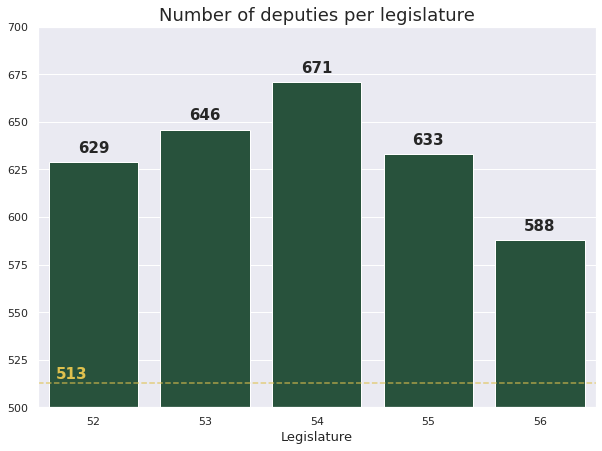

In [7]:
fig, ax = plt.subplots(figsize=(10,7))

sns.barplot(x = deputies.idLegislatura.value_counts().sort_index().index, 
            y = deputies.idLegislatura.value_counts().sort_index(), 
            color = "#21593b", ax = ax)

for index, value in deputies.idLegislatura.value_counts().sort_index().iteritems():
    ax.text(index-52, value+5, value, fontsize=15, ha='center', weight='bold')
    
ax.axhline(513, linestyle='--', color='#dfc14e', alpha=0.7)
ax.text(-0.2, 515, 513, fontsize=15, color='#dfc14e', ha='center', weight='bold')

ax.set_ylim((500,700))

ax.set_xlabel('Legislature', fontsize=13)
ax.set_ylabel('')
ax.set_title('Number of deputies per legislature', fontsize = 18)

plt.savefig('../images/deputies_legislature.png', bbox_inches='tight', dpi=600)
plt.show()

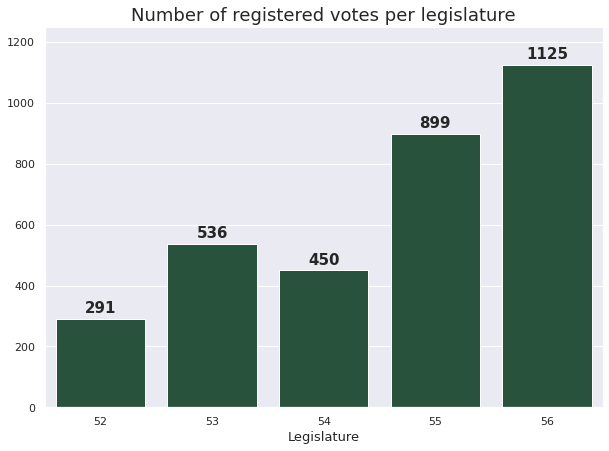

In [8]:
fig, ax = plt.subplots(figsize=(10,7))

sns.barplot(x = votings.legislature.value_counts().sort_index().index, 
            y = votings.legislature.value_counts().sort_index(), 
            color = "#21593b", ax = ax)

for index, value in votings.legislature.value_counts().sort_index().iteritems():
    ax.text(index-52, value+20, value, fontsize=15, ha='center', weight='bold')

ax.set_xlabel('Legislature', fontsize=13)
ax.set_ylabel('')
ax.set_title('Number of registered votes per legislature', fontsize = 18)

ax.set_ylim((0,1250))

plt.savefig('../images/votes_legislature.png', bbox_inches='tight', dpi=600)
plt.show()

## Building adjacency matrix

Below we build a preliminary network to the first presentation of the course. More robust construction is placed in the notebook `network_contruction.ipynb`.

In [9]:
number_edges = []
diameter = []

for legislature in trange(52, 57): 

    incidence_matrix = pd.read_csv('../data/tables/incidence_matrix_{}.csv'.format(legislature), index_col=0)
    incidence_matrix = incidence_matrix.replace({278: 0, 17: 0, 255: 0, 0.1: 0}).fillna(0)
    
    corr_function = lambda x, y: 0 if (x*y != 0).sum() == 0 else (x*y == 1).sum()/(x*y != 0).sum()
    incidence_corr = incidence_matrix.corr(method=corr_function)
    
    adj_matrix = 1*((incidence_corr > 0.75)&(incidence_corr < 1)) 

    G = nx.from_pandas_adjacency(adj_matrix)
    
    remove = [node for node,degree in dict(G.degree()).items() if degree < 1]

    G.remove_nodes_from(remove)
    
    number_edges.append((legislature, G.number_of_edges()))
    diameter.append((legislature, nx.diameter(G)))

  0%|          | 0/5 [00:00<?, ?it/s]

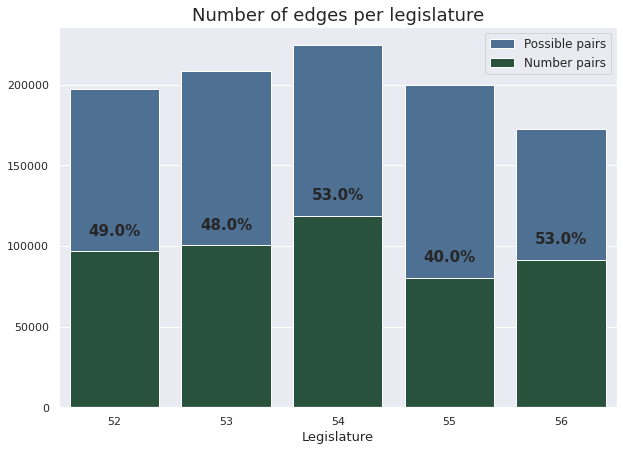

In [384]:
fig, ax = plt.subplots(figsize=(10,7))

possible_pairs = deputies.idLegislatura.value_counts().sort_index()*(deputies.idLegislatura.value_counts().sort_index()-1)/2

sns.barplot(x = [i[0] for i in number_edges], 
            y = possible_pairs, 
            color = "#41709f", ax = ax, 
            label='Possible pairs')

sns.barplot(x = [i[0] for i in number_edges], 
            y = [i[1] for i in number_edges], 
            color = "#21593b", ax = ax,
            label='Number pairs')

for index, value in number_edges:
    ax.text(index-52, value+10000, 
            str(100*round(value/possible_pairs.loc[index],2))+"%", 
            fontsize=15, ha='center', weight='bold')
    

ax.set_xlabel('Legislature', fontsize=13)
ax.set_ylabel('')
ax.set_title('Number of edges per legislature', fontsize = 18)

ax.legend(fontsize=12)

#ax.set_ylim((0,150000))

plt.savefig('../images/edges_legislature.png', bbox_inches='tight', dpi=600)
plt.show()

In [385]:
remove = [node for node,degree in dict(G.degree()).items() if degree < 1]

G.remove_nodes_from(remove)

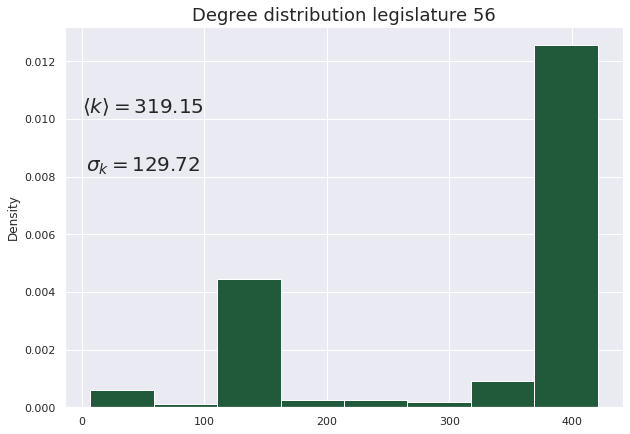

In [5]:
fig, ax = plt.subplots(figsize=(10,7))

degrees = dict(G.degree).values()

ax.hist(degrees, color = "#21593b", bins=8, density=True)

ax.set_ylabel('Density')
ax.set_title('Degree distribution legislature 56', fontsize = 18)

#ax.set_ylim((0,1250))

ax.text(0, 0.0102, r'$\langle k \rangle = {}$'.format(round(np.mean(list(degrees)),2)), 
        fontsize = 20, weight='bold')
ax.text(3, 0.0082, r'$\sigma_k = {}$'.format(round(np.std(list(degrees)),2)), 
        fontsize = 20, weight='bold')

#plt.savefig('../images/degree_distribution.png', bbox_inches='tight', dpi=600)
plt.show()

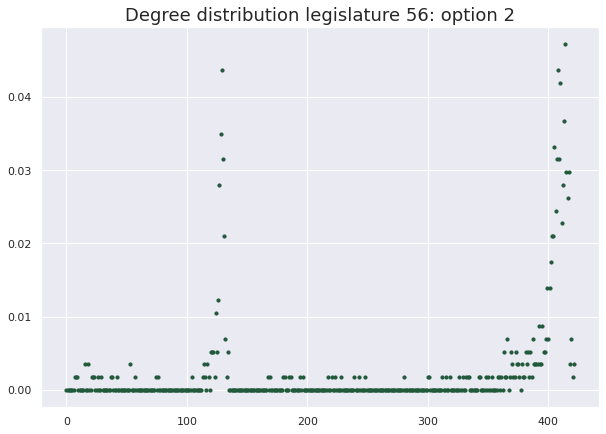

In [13]:
fig, ax = plt.subplots(figsize=(10,7))

degrees = nx.degree_histogram(G)
x = range(len(degrees))
y = [z/float(sum(degrees))for z in degrees]

ax.scatter(x,y,s=10,color = "#21593b")

ax.set_title('Degree distribution legislature 56: option 2', fontsize = 18)

#ax.text(0, 0.0102, r'$\langle k \rangle = {}$'.format(round(np.mean(list(degrees)),2)), 
#        fontsize = 20, weight='bold')
#ax.text(3, 0.0082, r'$\sigma_k = {}$'.format(round(np.std(list(degrees)),2)), 
#        fontsize = 20, weight='bold')

#plt.savefig('../images/degree_distribution.png', bbox_inches='tight', dpi=600)

plt.show()

In [396]:
parties = dict(zip(deputies[deputies.idLegislatura==56].id.astype(str), deputies[deputies.idLegislatura==56].siglaPartido))
nx.set_node_attributes(G, parties, 'party')

In [419]:
party_color = {'PT': '#CC0000', 'PSL': '#008000', 'PL': '#0F0073', 'PP': '#7DC9FF',
               'PSDB': '#0080FF', 'PSD':'#FFA500', 'MDB': '#30914D', 'REPUBLICANOS': '#005DAA', 
               'PSB': '#FFCC00', 'DEM': '#8CC63E', 'PDT': '#FF0000', 'SOLIDARIEDADE': '#FF9C2B', 
               'PROS': '#FF5460', 'PODE': '#2DA933', 'PTB': '#7B7B7B', 'PSC': '#009118', 
               'PSOL': '#700000', 'PCdoB': '#A30000', 'CIDADANIA': '#EC008C', 'AVANTE': '#ED5F36', 
               'NOVO': '#FF4D00', 'PATRIOTA': '#00A29B', 'PV': '#006600', 'REDE': '#379E8D', 'S.PART.': '#DDDDDD'}

#               'PR': 'blue', 'PRB': 'blue', 'PATRI': '#00A29B', 'PHS': 'blue', 'PPS': 'blue', 'PPL': 'blue',
#               'PRTB':'blue'}

colors = [party_color[G.nodes[n]['party']] for n in G.nodes]

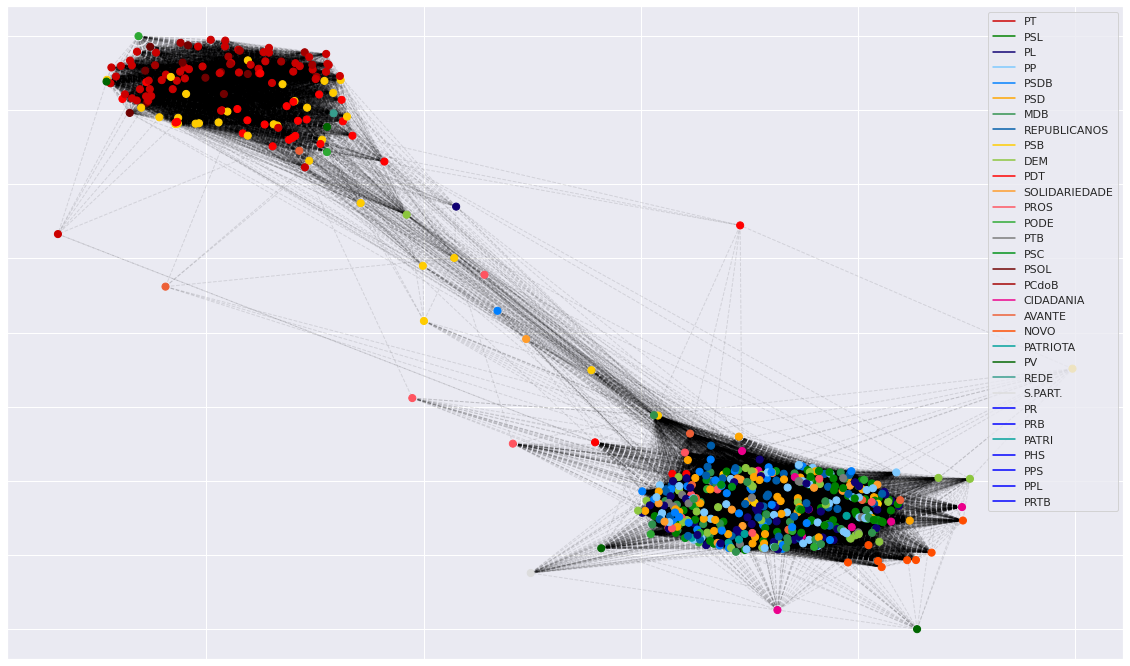

In [426]:
fig, ax = plt.subplots(figsize=(20,12))

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos=pos, node_size = 50, node_color = colors, ax = ax)
nx.draw_networkx_edges(G, pos=pos, edge_color='black', style='dashed',alpha =0.1, ax = ax)

for label,color in party_color.items():
    ax.plot([0],[0],
            color=color,
            label=label)
    
ax.legend()
plt.savefig('../images/network-56.png', bbox_inches='tight', dpi=400)
plt.show()

Estatísticas de G

In [422]:
print(nx.info(G))
print(nx.diameter(G))

Name: 
Type: Graph
Number of nodes: 572
Number of edges: 91278
Average degree: 319.1538
3


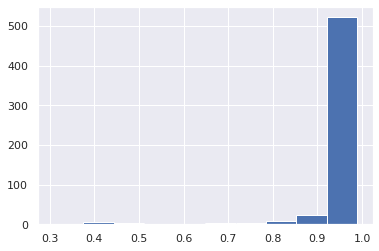

In [393]:
plt.hist(nx.clustering(G).values())
plt.show()

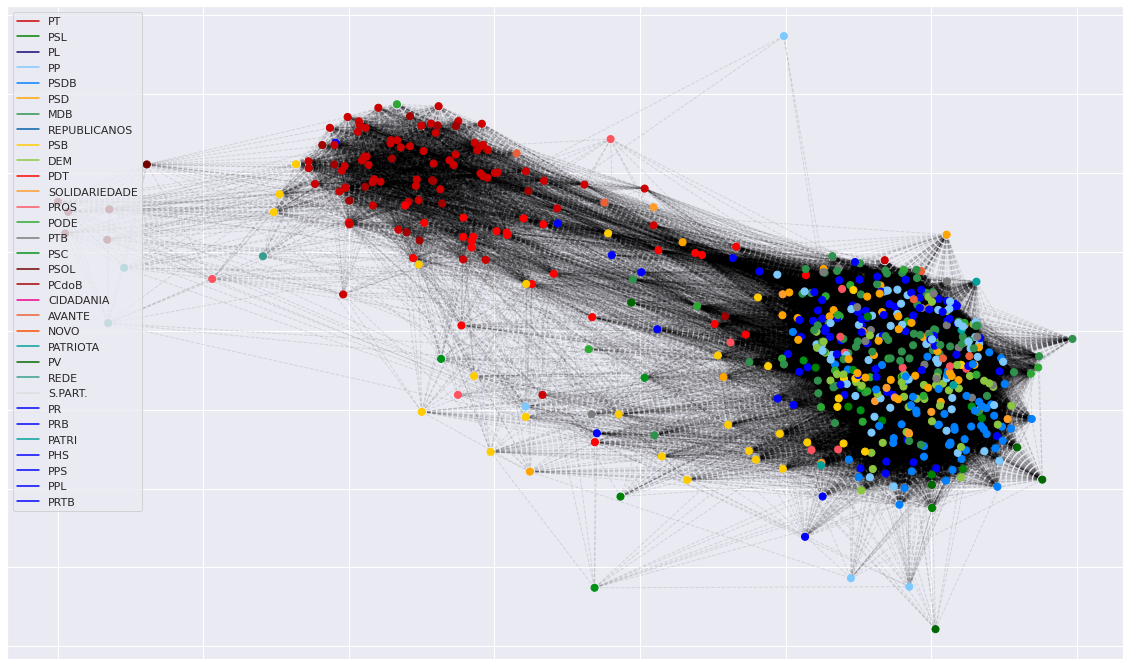

In [427]:
incidence_matrix = pd.read_csv('../data/tables/incidence_matrix_55.csv', index_col=0)
incidence_matrix = incidence_matrix.replace({278: 0, 17: 0, 255: 0, 0.1: 0}).fillna(0)

incidence_corr = incidence_matrix.corr(method=corr_function)

adj_matrix = 1*((incidence_corr > 0.75)&(incidence_corr < 1)) 

G = nx.from_pandas_adjacency(adj_matrix)
remove = [node for node,degree in dict(G.degree()).items() if degree < 1]
G.remove_nodes_from(remove)

parties = dict(zip(deputies[deputies.idLegislatura==55].id.astype(str), deputies[deputies.idLegislatura==55].siglaPartido))
nx.set_node_attributes(G, parties, 'party')

party_color.update({'PR': 'blue', 'PRB': 'blue', 'PATRI': '#00A29B', 'PHS': 'blue', 'PPS': 'blue', 'PPL': 'blue', 'PRTB':'blue'})

colors = [party_color[G.nodes[n]['party']] for n in G.nodes]

fig, ax = plt.subplots(figsize=(20,12))

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos=pos, node_size = 50, node_color = colors, ax = ax)
nx.draw_networkx_edges(G, pos=pos, edge_color='black', style='dashed',alpha =0.1, ax = ax)

for label,color in party_color.items():
    ax.plot([0],[0],
            color=color,
            label=label)
    
ax.legend()
plt.savefig('../images/network-55.png', bbox_inches='tight', dpi=400)
plt.show()